----
### 05. Results Analysis
and
**Objective:**  To analyse the trained and tuned models and their performances and select the best model readily for production. In addition, to conduct an in-depth analysis for the best-performing model and perform an unseen-data performance comparison for all models. Finally, to present a client API for utilisation of the recommended model for ease and convenience.

---

### 5.1 Loading Trained Models and Data

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent  # go up from notebooks/ to project root
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
from src.data_loader import load_data
from src.model import test_evaluation, compare_test_metrics

In [3]:
from joblib import load, dump

X_train = load("../data/X_train.joblib")
X_test = load("../data/X_test.joblib")
y_train = load("../data/y_train.joblib")
y_test = load("../data/y_test.joblib")

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845,), (56962, 30), (56962,))

In [5]:
lr_baseline = load("../trained_models/logistic_regression_baseline.joblib")
catboost_default = load("../trained_models/catboost_default.joblib")
lightgbm_default = load("../trained_models/lightgbm_default.joblib")
rf_default = load("../trained_models/random_forest_default.joblib")

rf_tuned = load("../trained_models/random_forest_tuned_for_pr_auc.joblib")
lightgbm_tuned = load("../trained_models/lightgbm_tuned_for_pr_auc.joblib")
catboost_tuned = load("../trained_models/catboost_tuned_for_pr_auc.joblib")

----
### 5.2 OOF (out-of-fold) CV Comparison and Best Model Selection

The table below displays OOF metrics `(positive-class metrics only)` as produced by the OOF comparison at the end on modelling section, `sorted descending by val PR AUC`.


In [6]:
load_oof_val_metrics = True

if load_oof_val_metrics:
    oof_val_metrics = load_data("../results/tables/oof_validation_metrics_all_models.csv")

oof_val_metrics

,model,precision,recall,f1-score,support,val pr auc,val roc auc
0,LightGBM (Tuned),0.940,0.832,0.883,394.0,0.863,0.974
1,CatBoost (Tuned),0.960,0.802,0.874,394.0,0.856,0.977
2,LightGBM (Default),0.827,0.838,0.832,394.0,0.848,0.976
3,Random Forest (Tuned),0.881,0.805,0.841,394.0,0.839,0.979
4,CatBoost (Default),0.798,0.853,0.825,394.0,0.832,0.974
5,Random Forest (Default),0.835,0.810,0.822,394.0,0.803,0.975
6,Logistic Regression (Baseline),0.053,0.893,0.100,394.0,0.756,0.979


#### Production Candidate:
The tuned `LightGBM (Tuned)`model achieved the highest OOF PR AUC (0.863) and the highest F1-score for `the positive (fraud) class`:

- Precision = 0.94 for `the positive class`, indicating a high proportion of predicted positives are true positives.

- Recall = 0.832 for `the positive class`, indicating high coverage of actual positives. This combination of metrics makes it the best candidate for production.

In [7]:
oof_val_metrics.iloc[[0],:]

,model,precision,recall,f1-score,support,val pr auc,val roc auc
0,LightGBM (Tuned),0.94,0.832,0.883,394.0,0.863,0.974


In [8]:
production_model = lightgbm_tuned

-----

### 5.3 Production Model OOF Diagnostics — PR curve, Precision-Recall vs. Thresholds



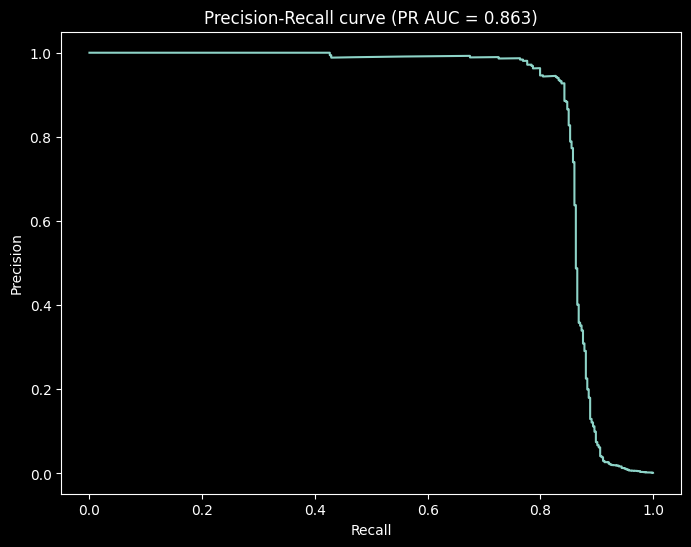

In [9]:
from src.model import pr_curve_oof, pr_vs_threshold_curve_oof

pr_auc_best_model, oof_y_probabilities_best_model = pr_curve_oof(production_model, X_train, y_train)

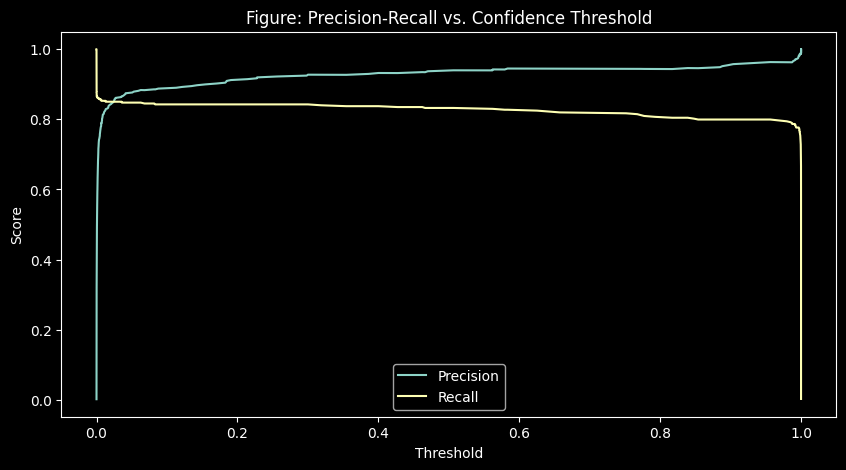

In [10]:
pr_vs_threshold_curve_oof(y_train, oof_y_probabilities_best_model)

---
### 5.4 OOF Probabilities Calibration
(How Accurate Are the Probabilities Produced by the Model!)
#### Brier Score
Brier Score is the mean squared error between predicted probability and the actual label (0 or 1): measures how close the predicted probabilities are to the true outcomes:

In [25]:
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y_train, oof_y_probabilities_best_model)

brier_score

0.00036867656628361713

**Analysis:**
- Perfect model brier score = 0, worse models have higher values (up to 1).
- The selected production model's brier score is calculated using `Out-of-fold (OOF) probabilities`.
- The score is `very low` `~0.00037` which means the predicted OOF probabilities are almost identical to the true outcomes/lables.
- This extremely low brier score means the model produces **realistic and trustworthy probabilites**, and no further probability calibatrion is required.